In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
tf.enable_eager_execution()


from tensorflow.keras import layers
from tensorflow.distributions import Bernoulli
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import tensorflow.keras as K
from tensorflow.keras import backend as Kb
import numpy as np
import pandas as pd
from importlib import reload

tf.enable_eager_execution()
print(tf.executing_eagerly())


print(tf.__version__)
print(K.__version__)
print(tf.test.is_gpu_available())

True
1.15.0
2.2.4-tf
True


In [0]:
BATCH_SIZE = 128
LATENT_K = 5
LATENT_N = 10
LR = 0.002
TAU0 = 1.
ANNEAL_RATE = 0.00001
MIN_TEMP = 0.4
EPOCHS = 20
SIZE = 28
MODEL_TYPE = 'conv'

In [3]:
### loading mnist data
(train_images, y_train), (test_images, y_test) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape((-1,28,28,1)).astype('float32')
test_images = test_images.reshape((-1,28,28,1)).astype('float32')
train_images /= 255.
test_images /= 255.

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.distributions import Bernoulli
import tensorflow.keras as K
from tensorflow.keras import backend as Kb
import numpy as np


def make_model(type_, SIZE, LATENT_K, LATENT_N, LR=1e-4, beta=1.):
    
    if type_ == 'conv':
        # Encoder
        encoder_inputs = layers.Input(shape=(SIZE,SIZE,1), name='encoder_input')
        x = layers.Conv2D(filters=8, kernel_size=5, padding='SAME',activation='relu',strides=(2,2))(encoder_inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters=16, kernel_size=5, padding='SAME',activation='relu',strides=(2,2))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Flatten()(x)
        x = layers.Dense(units=LATENT_K*LATENT_N, activation=None, name='encoded')(x)
        encoded = layers.Reshape((LATENT_N, LATENT_K))(x)
        encoder = K.Model(inputs=encoder_inputs, outputs=encoded, name='encoder')


        # Decoder
        decoder_inputs = layers.Input(shape=(LATENT_N, LATENT_K,), name='decoder_input')
        y = layers.Flatten()(decoder_inputs)
        y = layers.Dense(units=7*7*4, activation='relu')(y)
        y = layers.Reshape((7,7,4))(y)
        y = layers.Conv2DTranspose(filters=8,kernel_size=4,strides=(2, 2), padding="SAME", activation='relu')(y)
        y = layers.Conv2DTranspose(filters=16,kernel_size=4,strides=(2, 2), padding="SAME", activation='relu')(y)
        decoded = layers.Conv2DTranspose(filters=1,kernel_size=4,strides=(1, 1), padding="SAME", name='output')(y)
        decoder = K.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')
    
    
    
    elif type_ == 'mlp':
        # Encoder
        encoder_inputs = layers.Input(shape=(SIZE, SIZE, 1), name='encoder_input')
        inputs_reshape = layers.Reshape((SIZE*SIZE,))(encoder_inputs)
        x = layers.Dense(50, activation='relu')(inputs_reshape)
        x = layers.Dense(100, activation='relu')(x)
        x = layers.Dense(units=LATENT_K*LATENT_N, activation=None, name='encoded')(x)
        encoded = layers.Reshape((LATENT_N, LATENT_K))(x)
        encoder = K.Model(inputs=encoder_inputs, outputs=encoded, name='encoder')


        # Decoder
        decoder_inputs = layers.Input(shape=(LATENT_N, LATENT_K,), name='decoder_input')
        y = layers.Flatten()(decoder_inputs)
        y = layers.Dense(100, activation='relu')(y)
        y = layers.Dense(50, activation='relu')(y)
        y = layers.Dense(SIZE*SIZE, activation='relu')(y)
        decoded = layers.Reshape((SIZE, SIZE, 1))(y)
        decoder = K.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')
        
        
    # latent gumbel-softmax
    class Gumbel_Softmax(layers.Layer):

        def __init__(self, tau0=1.):
            super(Gumbel_Softmax, self).__init__()
            self.tau = tau0


        def sample_gumbel(self, shape, eps=1e-20): 
            u = tf.random.uniform(shape,minval=0,maxval=1)
            return -tf.log(-tf.log(u + eps) + eps)


        def gumbel_softmax_sample(self, logits): 
            y = logits + self.sample_gumbel(tf.shape(logits))
            return tf.nn.softmax( y / self.tau, axis=-1)


        def call(self, inputs, hard=False):
            y = self.gumbel_softmax_sample(inputs)

            if hard: # one hot
                k = tf.shape(logits)[-1]
                y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keep_dims=True)),y.dtype)
                y = tf.stop_gradient(y_hard - y) + y
            return y


    latent_input = layers.Input(shape=(LATENT_N, LATENT_K), name='latent_input')
    gumble_softmax = Gumbel_Softmax()
    z_latent = gumble_softmax(latent_input)
    latent_sampler = K.Model(inputs=latent_input, outputs=z_latent, name='gumble_softmax_sampler')


    # whole model
    model_inputs = layers.Input(shape=(SIZE,SIZE,1), name='model_input')
    z_e = encoder(model_inputs)
    z_q = latent_sampler(z_e)
    output = decoder(z_q)
    categorical_vae = K.Model(inputs=model_inputs, outputs= output, name="categorical_vae")


    # Loss
    q_y = tf.nn.softmax(z_e, axis=-1)
    log_q_y = tf.log(q_y+1e-20)
    kl_loss = tf.reduce_sum(q_y*(log_q_y-tf.log(1.0/LATENT_K)), axis=[1,2])
    categorical_vae.add_loss(tf.reduce_mean(kl_loss)*beta)
    categorical_vae.compile(loss='mse', optimizer=K.optimizers.Adam(LR))

    # generative model
    gen_inputs = layers.Input(shape=(LATENT_N, LATENT_K), name='generative_input')
    dec_out = decoder(gen_inputs)
    generative_model = K.Model(inputs=gen_inputs, outputs=dec_out, name='generative_model')
    
    categorical_vae.summary()

    return categorical_vae, generative_model, encoder, decoder, gumble_softmax

In [6]:
model, generative_net, encoder, decoder, gumble_softmax = make_model(MODEL_TYPE, SIZE, LATENT_K, LATENT_N, 2e-3, 1.)


Model: "categorical_vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 10, 5)        42770       model_input[0][0]                
__________________________________________________________________________________________________
gumble_softmax_sampler (Model)  (None, 10, 5)        0           encoder[1][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 28, 28, 1)    12837       gumble_softmax_sampler[1][0]     
___________________________________________________________________________________

In [10]:
## training
h = []
for i in tqdm(range(200)):
    temp = model.fit(train_images, train_images, epochs=1, batch_size=BATCH_SIZE, verbose=0)
    gumble_softmax.tau = np.maximum(TAU0*np.exp(-ANNEAL_RATE*i),MIN_TEMP)
    l = temp.history['loss']
    h += [l]
    if (i+1) % 10 == 0:
        print('epoch:',i+1, ' loss:', l)

epoch: 10  loss: [0.06731450294653575]
epoch: 20  loss: [0.06731302227576574]
epoch: 30  loss: [0.06731836402813593]
epoch: 40  loss: [0.06732307840585709]
epoch: 50  loss: [0.06729692424138387]
epoch: 60  loss: [0.06730679931243261]
epoch: 70  loss: [0.06729795387585957]
epoch: 80  loss: [0.06730303279558818]
epoch: 90  loss: [0.06730809051195781]
epoch: 100  loss: [0.0673046325882276]
epoch: 110  loss: [0.06729855581521987]


KeyboardInterrupt: ignored

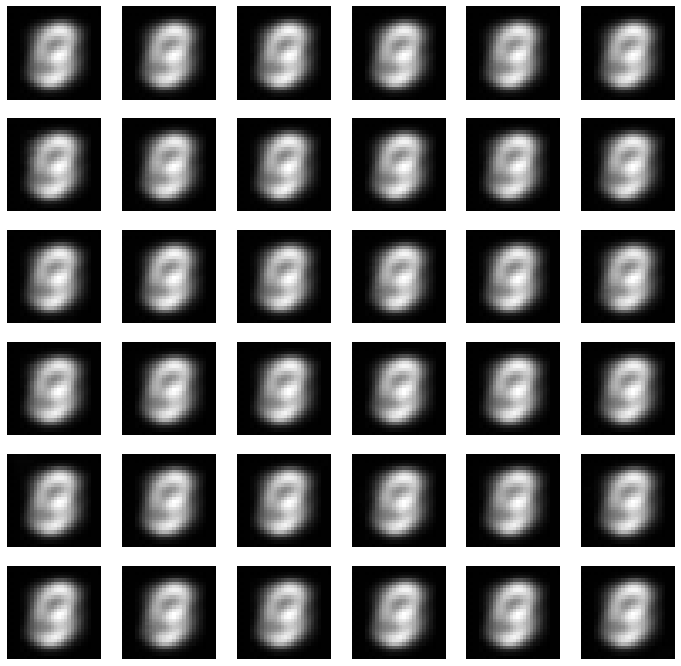

In [11]:
def generate(m,n):
    total=m*n*LATENT_N
    np_y = np.zeros((total,LATENT_K))
    np_y[range(total),np.random.choice(LATENT_K,total)] = 1
    np_y = np.reshape(np_y,[m*n,LATENT_N,LATENT_K])
    gen = generative_net.predict(np_y)
    
    plt.figure(figsize=(m*2,2*n))
    for i in range(m*n):
        plt.subplot(m, n, i+1)
        plt.imshow(gen[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()
    
generate(6,6)

(64, 28, 28, 1)


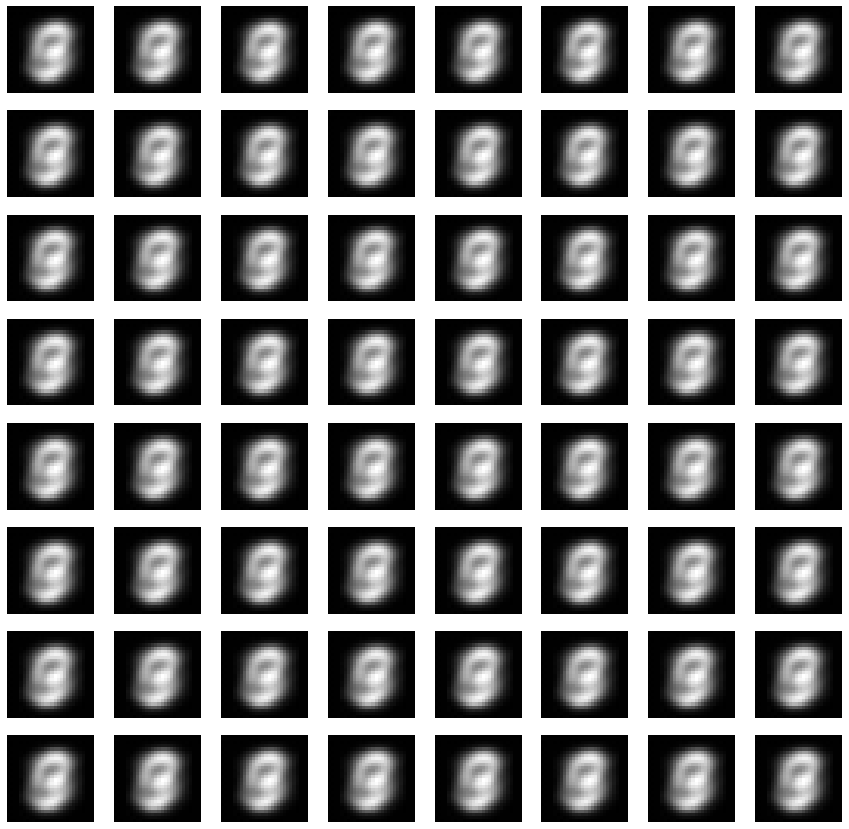

In [12]:
def reconstruct(m, n, data):
    total=m*n
    recons = model.predict(data[:total],steps=1)
    print(recons.shape)
    
    plt.figure(figsize=(15, 15))
    for i in range(total):
        plt.subplot(m, n, i+1)
        plt.imshow(recons[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()

reconstruct(8,8,test_images)